# Imports and dataset loading

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

originalDataSet = pd.read_csv('dataset', sep=',',header = None)
scaler = MinMaxScaler()

def load_dataset():    
    scaler.fit(originalDataSet.values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

# Cross validation function

In [71]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)    
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [72]:
def trainModel(strategy):
    features, result = load_dataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    #print(getName(strategy))
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    plotError(gainErrors, lossErrors, strategy)

# Plotting error boxplot

In [73]:
def getName(strategy):
    if isinstance(strategy, DecisionTreeRegressor) :
        return "Decision Tree"
    
    if isinstance(strategy, RandomForestRegressor) :
        return "Random Forest"
    
    if isinstance(strategy, MultiOutputRegressor) :
        if(strategy.estimator.kernel == "rbf"):
            return "SVR (radial kernel)"
        else:
            return "SVR (linear kernel)"

In [74]:
def plotError(gainErrors, lossErrors, strategy):
    fig7, axis = plt.subplots()
    data       = [gainErrors, lossErrors]

    axis.boxplot(data)
    axis.set_title(getName(strategy))
    axis.set_xticklabels(np.repeat(["Gain", "Loss"], 1))
    axis.set_ylabel("Absolute error")

    plt.show()

# Putting all together

[2.14056241 2.25171463 2.76231844 2.54193269 2.63701051] => 2.47 (+/- 0.47)
[2.25774984 1.72657658 1.73011226 2.26967934 1.24351321] => 1.85 (+/- 0.77)


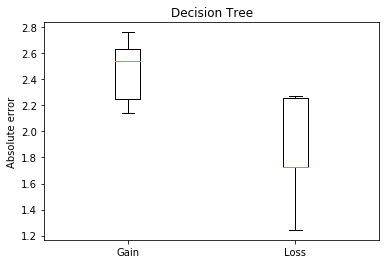

In [75]:
regressionTree = DecisionTreeRegressor(max_depth = 8)
trainModel(regressionTree)

[3.05147612 2.83995014 2.77142105 3.01725143 2.8654347 ] => 2.91 (+/- 0.21)
[2.06537041 1.6955493  1.85067958 1.60601904 1.20084246] => 1.68 (+/- 0.57)


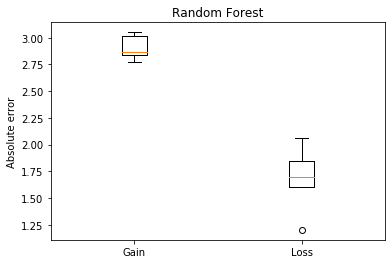

In [76]:
randomForest = RandomForestRegressor(max_depth = 2, random_state = 0, n_estimators = 100)
trainModel(randomForest)

[3.64756447 3.16045845 3.00286533 3.02005731 2.6991404 ] => 3.11 (+/- 0.62)
[5.6747851  6.41547278 6.11747851 6.34097421 6.59885387] => 6.23 (+/- 0.63)


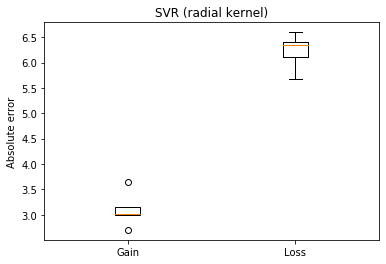

In [77]:
radialSVR = MultiOutputRegressor(SVR(C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(radialSVR)

[3.64756447 3.16045845 3.00286533 3.02005731 2.6991404 ] => 3.11 (+/- 0.62)
[5.6747851  6.41547278 6.11747851 6.34097421 6.59885387] => 6.23 (+/- 0.63)


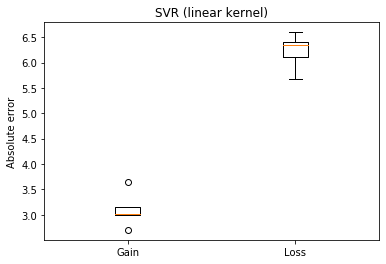

In [78]:
linearSVR = MultiOutputRegressor(SVR(kernel = "linear", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)